 _В данном проекте:_ 
- [x] [А/B-тестирование](#A/B–тестирование)
- [x] [Функция подгрузки](#Функция-подгрузки)

### <b>Загрузим библиотеки и вспомогающие функции:</b>
--------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from pingouin import chi2_independence
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu

# Библиотеки для функции отображения нескольких таблиц: 
from IPython.display import display_html
from itertools import chain, cycle

# Библиотеки для игнорирования ошибок:
import warnings
warnings.filterwarnings("ignore")

# Функция для отображения нескольких таблиц в одном окне:
def display_side_by_side(*args, titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

### <b>A/B–тестирование</b> 

#### 1.1 Постановка задачи 
________________________

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
Основное:
- [x] Тестируем новую механику оплаты услуг на сайте
- [x] Две группы: целевая и контрольная
- [x] Используем метод A/B-тестирования 

#### 1.2 Входные данные
_______________________
Имеем 4 csv-файла:
- [x] groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
(А – контроль, B – целевая группа) 
- [x] groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- [x] active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- [x] checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

#### 1.3 Ходы решения:
_____________
- [ ] Загрузка данных 
- [ ] Проведение EDA 
- [ ] Объединяем и анализируем данные
- [ ] Определение, анализ и А/Bтестирование метрик


- [x] __Загружаем данные__ 
_______________

In [2]:
groups=pd.read_csv('groups.csv', sep =';')
gr_add=pd.read_csv('group_add.csv', sep =',')
active=pd.read_csv('active_studs.csv', sep =';')
checks=pd.read_csv('checks.csv', sep =';')

- [x] __Проводим разведочный анализ данных EDA__
__________________

#### В данных имеем следующую информацию:
 - id пользователей
 - принадлежность пользователя к группе
 - допольнительных пользователей
 - id пользователей, кто зашел на платформу
 - id пользователей, кто купил продукт
 - доход с каждого пользователя


##### Смотрим общую информацию датасетов
-----------

In [3]:
groups.info()
gr_add.info()
active.info()
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dty

__Вывод:__   
Название колонок в двух датасетах отличаются(далее приведём к одному типу)   
Количество строк нормальное.   
Пропущенных значений не выявлено.   
Типы данных устраивают.

##### Смотрим количество уникальных значений:
-----------

In [4]:
display_side_by_side(groups.nunique().reset_index(),
                        gr_add.nunique().reset_index(),
                        active.nunique().reset_index(),
                        checks.nunique().reset_index(),
                        titles=['groups', 'gr_add','active', 'checks'])

,index,0
0,id,74484
1,grp,2
,index,0
0,id,92
1,grp,2
,index,0
0,student_id,8341
,index,0
0,student_id,541
1,rev,39


__Вывод:__     
Количество уникальных значений совпадает с количеством строк в датасетах.

__Поиск пропущенных значений:__
________________

In [5]:
display_side_by_side(groups.isnull().sum().reset_index(),
                        gr_add.isnull().sum().reset_index(),
                        active.isnull().sum().reset_index(),
                        checks.isnull().sum().reset_index(),
                        titles=['groups', 'gr_add','active', 'checks'])

,index,0
0,id,0
1,grp,0
,index,0
0,id,0
1,grp,0
,index,0
0,student_id,0
,index,0
0,student_id,0
1,rev,0


__Вывод:__      
Пропущенных значений нет!

- [x] __Объединяем и анализируем данные всех датасетов__
--------------

__Переименовываем столбцы student_id в id__ 
____________________

In [6]:
checks = checks.rename(columns={'student_id':'id'})
active = active.rename(columns={'student_id':'id'})


__Объединяем основной дата-сет с пользователями (groups) с дополнительным(gr_add), который прислали спустя 2 дня.__     
________________

In [8]:
combined_groups  = pd.concat([groups, gr_add],ignore_index=True, sort=False)

__Сразу проверяем правильно ли мы объеденили, сравнивая сумму строк датасетов groups и gr_add с combined_groups.__
_____________________

In [9]:
print('Разница между суммой двух датасетов (groups и gr_add) и склееным датасетом combined_groups: \n')
print('groups (',groups.shape[0],')'' + gr_add (',gr_add.shape[0],') - combined_groups (',combined_groups.shape[0],') =',
      groups.shape[0] + gr_add.shape[0] - combined_groups.shape[0] )

Разница между суммой двух датасетов (groups и gr_add) и склееным датасетом combined_groups: 

groups ( 74484 ) + gr_add ( 92 ) - combined_groups ( 74576 ) = 0


In [10]:
combined_groups.nunique()

id     74576
grp        2
dtype: int64

__Вывод:__   
Разница равна 0, количество уникальных значений сохранено - объеденили верно!

__Объединяем все данные в единый датасет:__   
______________
 - Создаем булевую колонку, присвающее значе True - пользователям которые заходили на платформу и False - обратное, путем сравнение id датасета "combined_groups" c id датасета "ative"(предоставляющий данные о пользователях заходивших на платформу)   
 - Объединяем полученный датасет и checks.

In [11]:
combined_groups['active'] = np.isin(combined_groups['id'], active['id']).tolist()
Full_data = combined_groups.merge(checks, how = 'left', on = 'id' )

__Сразу проверяем правильно ли мы объеденили,сравнивая суммы строк датасетов__
________________________

In [12]:
print('Разница между значениями кол-ва активных студентов в склееном датасете(Full_data) и изначальном датасете (active): \n')
print('Full_data (',Full_data.shape[0],')'' - combined_groups (',combined_groups.shape[0],') =',
      Full_data.shape[0] - combined_groups.shape[0], '\n')


print('Разница между значениями кол-ва активных студентов в склееном датасете(Full_data) и изначальном датасете (active): \n')
print('Full_data (',Full_data.query('active == True').shape[0],')'' - active (',active.shape[0],') =',
      Full_data.query('active == True').shape[0] - active.shape[0], '\n')

print('Разница между значениями кол-ва платящих студентов в склееном датасете(Full_data) и изначальном датасете (checks): \n')
print('Full_data (',Full_data.query('rev > 0').shape[0],')'' - checks (',checks.shape[0],') =',
      Full_data.query('rev > 0').shape[0] - checks.shape[0], '\n')


Разница между значениями кол-ва активных студентов в склееном датасете(Full_data) и изначальном датасете (active): 

Full_data ( 74576 ) - combined_groups ( 74576 ) = 0 

Разница между значениями кол-ва активных студентов в склееном датасете(Full_data) и изначальном датасете (active): 

Full_data ( 8341 ) - active ( 8341 ) = 0 

Разница между значениями кол-ва платящих студентов в склееном датасете(Full_data) и изначальном датасете (checks): 

Full_data ( 541 ) - checks ( 541 ) = 0 



__Вывод:__   
Разница равна 0 - объеденили верно!

__Проверяем на ошибки полный датасет__
________________

In [13]:
Full_data.query('active == False & rev > 0').rev.unique()

array([ 690.    ,  630.    ,  580.    ,  290.    , 1140.    ,  990.    ,
        199.    , 1900.    , 1980.    , 1180.    ,  840.    , 1900.0001,
        398.    ])

In [14]:
Full_data.query('active == False & rev > 0')\
    .groupby('grp',as_index=False)\
    .agg({'active':'count'})

,grp,active
0,A,29
1,B,120


__Обнаружил, что в нашем общем датасете есть пользователи, которых система регистрирует как незаходящих на платформу (149 пользователей), НО! при этом фиксируется факт оплаты.__

__Вывод:__  
Проанализоровав данные этих пользователей, выявил, что эти пользователи распределены не равномерно между группами, большинство (120) пользователей принадлежит целевой группе, а 29 пользователей контрольной. Так же суммы оплаты имеют разные значения - 13 уникальных значений.

1) Система дала сбой и не зафиксировала факт посещения платформы.

2) Транзакция была зафиксирована уже после введения новой фичи.

2) Оплата с других ресурсов, либо автоматическое списание.

Не владеем полным спеком данных и возможности обговорить с заказчиком, считаю, что раз уж количество пользователей имеет большой перевес в сторону целевой группы - то это может повлиять на данные. Далее будем игнорировать эти данные.

__Проверим на пропущенные значения полный датасет.__
_______________

In [15]:
Full_data.isnull().sum()

id            0
grp           0
active        0
rev       74035
dtype: int64

__Вывод:__   
Объединяя наши датасеты, у нас появились пропущенные (это связано с тем, что мы добавили доход с каждого пользователя, но многие не платили).   
Заменим значения Nan в rev на нули и создадим булевую колонку (1 - была покупка, 0 - нет) для удобства расчётов.

In [16]:
Full_data['purchase']=np.where(Full_data.rev.isna(), 0, 1) 
Full_data.rev.fillna(0, inplace=True)

__Вывод__    
Датасет готов к анализу!

- [x] __Определение, анализ и А/Bтестирование метрик__
_________________

Тестируем новую механику оплаты - рассмотрим две важные метрики "Conversion Rate" и "Average Order Value"

__Перейдём к расчёту CR :__
_________________

 - Возьмем только пользолвателей посетивших платформу во время проведения эксперимента.   
 - Создадим новую колонку, куда поместим посетивших и совершивших оплату пользователей.
 - Посчитаем CR.

In [17]:
CR = Full_data.query('active==True')\
    .groupby('grp', as_index=False) \
    .agg({'active':'count'})\
    .rename(columns = {'active':'visitors'})

CR['payment'] = Full_data.query('active==True & rev > 0')\
                .groupby('grp')\
                .agg({'active':'count'})\
                .active.to_list()

CR['conv_rate'] = round((CR.payment / CR.visitors) * 100, 2)
CR

,grp,visitors,payment,conv_rate
0,A,1538,78,5.07
1,B,6803,314,4.62


__Визиализируем полученные CR__
______________________

Text(0.5, 1.0, 'conv_rate A vs B')

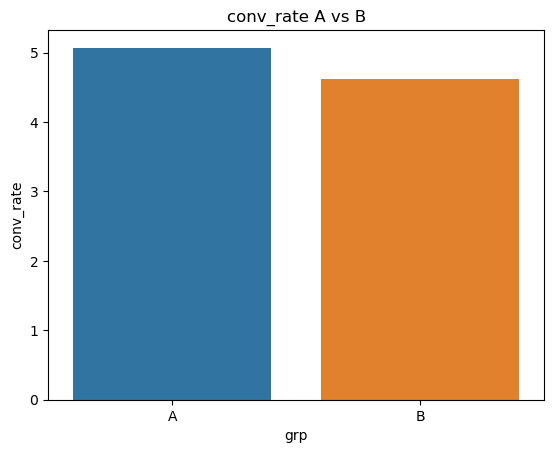

In [18]:
sns.barplot(x="grp", y="conv_rate", data=CR).set_title("conv_rate A vs B")

__Вывод__   
Наблюдаем, что конверсия в покупку между группами имеет небольшую разность.

__A/B - тестирование CR метрики__   
Определяем статистически значимо различаются конверсии в покупку.    
__Определяем гипотезы__   
Нулевая гипотеза (H0): Разницы между конверсией в покупку в тестовой и контрольной группе нет.    
Альтернативная гипотеза (H1): Разница между конверсией в покупку в тестовой и контрольной группе есть.

__P.S.__ Так как данные (purchase и grp) являются категориальными переменными, то будем использовать  t-тест и тест Хи-квадрат!

__Создадим новые переменные, где разобъем пользователей на группы и возьмём только тех кто совершил оплату:__
______________

In [19]:
AB_test_A = Full_data.query('active==True & grp == "A"')
AB_test_B = Full_data.query('active==True & grp == "B"')

In [20]:
 ttest_ind(AB_test_A.purchase, AB_test_B.purchase)

Ttest_indResult(statistic=0.7629235937766906, pvalue=0.445530545137386)

In [21]:
expected, observed, stats = chi2_independence(Full_data.query('active==True'), x='purchase', y='grp')

In [22]:
display_side_by_side(expected, observed,
                    titles=['Наблюдаемые значения', 'Ожидаемые значения'])


grp,A,B
purchase,,
0,1465.718979,6483.281021
1,72.281021,319.718979
grp,A,B
purchase,,
0,1460.5,6488.5
1,77.5,314.5


In [23]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


__Вывод__
 - Получили значения pvalue, которое превышает значение 0.05. Это означет, что статистически мы подтвердили, что оснований отклонить гипотезу H0 у нас нет.
 - Так же наблюдаем низкие значения мощности ~ 11%. Данные низкие значения мощности говорят нам о том, что мы имеем высокие (89%) шансы столкнуться с ошибкой 2 рода. Иными словами: на 89% мы столкнулись с "Ложноотрицательным решением". 

__Перейдём к расчёт Average Order Value — средний чек__
_____________

In [24]:
AOV_A = AB_test_A.query('purchase == 1').rev.mean().round(2)
AOV_B = AB_test_B.query('purchase == 1').rev.mean().round(2)
print('группа А :', AOV_A, 'Группа B :',AOV_B )

группа А : 933.59 Группа B : 1257.88


__Рассмотрим количества значений чеков__

In [25]:
AB_test_A.query('purchase == 1').rev.value_counts()

290.0     25
580.0      6
990.0      5
199.0      5
590.0      5
690.0      4
3660.0     3
1530.0     3
840.0      3
2820.0     2
1140.0     2
2910.0     2
489.0      2
1160.0     2
1039.0     1
2890.0     1
2220.0     1
1180.0     1
398.0      1
1830.0     1
1980.0     1
2900.0     1
870.0      1
Name: rev, dtype: int64

In [26]:
AB_test_B.query('purchase == 1').rev.value_counts()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
580.0000      5
870.0000      5
1530.0000     5
2890.0000     3
2099.0000     3
3660.0000     2
1980.0000     2
2910.0000     2
597.0000      1
1339.0000     1
489.0000      1
1968.0000     1
1050.0000     1
2220.0000     1
880.0000      1
1388.0000     1
1729.0000     1
2190.0000     1
4650.0000     1
796.0000      1
3040.0000     1
3260.0000     1
1160.0000     1
Name: rev, dtype: int64

__Визуализируем AOV__
_______________

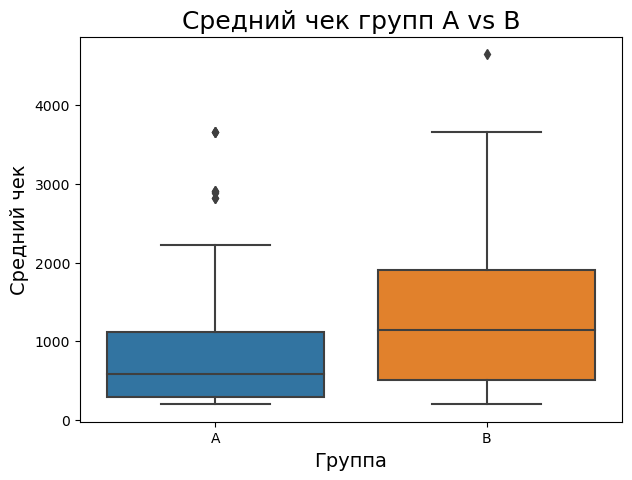

In [28]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='grp',
            y='rev',
            data=Full_data.query('active==True & purchase == 1'))
plt.ylabel("Средний чек", size=14)
plt.xlabel("Группа", size=14)
plt.title("Средний чек групп А vs B", size=18)
plt.show()

<Axes: xlabel='rev', ylabel='Density'>

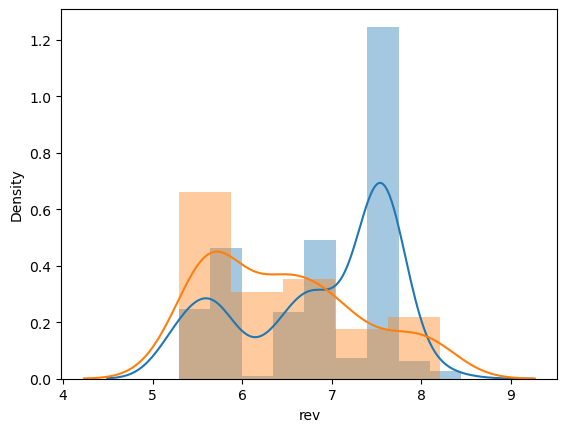

In [29]:
sns.distplot(np.log(AB_test_B.query('purchase == 1').rev))
sns.distplot(np.log(AB_test_A.query('purchase == 1').rev))

__По боксплоту можем сделать несколько выводов:__
 - В обеих группах замечаны выбросы
 - Медианы имею различие
 - AOV в группе B имеет больший межквартильный размах
 - Распределение является не нормальным 
 
Анализируя сделаные выводы, приходим к выводу, что нам нужно использовать __Вootstrap__.

__Вootstrap__
______________

__Гипотезы__   
H0 - разницы между средними значениями среднего чека двух групп нет;    
H1 - разница между средними значениями есть

In [30]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

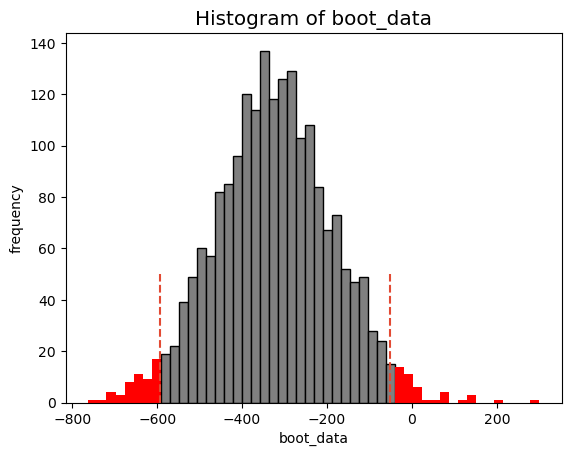

0.01954116312282793

In [31]:
get_bootstrap(AB_test_A.loc[AB_test_A.purchase == 1].rev, 
              AB_test_B.loc[AB_test_B.purchase == 1].rev, 
              2000, np.mean, 0.95)['p_value']

__Вывод__
 - При использовании Вootstrap получили значения pvalue, которое не на много ниже 0.05 и 0 не входит в доверительный интервал.      
Это означет, что статистически мы подтвердили, что средний чек в обоих группах различается.


### <b>Выводы по A/B–тестирование </b>   
___________
__Анализ конверсии в покупку__
 - На боксплоте мы заметили небольшие различия между группами.
 - Используя тест Хи-квадрат мы подтвердили, что оснований отклонить нулевую гипотезу (Разницы между конверсией в покупку в тестовой и контрольной группе нет) у нас нет.
 - Наблюдаем низкие значения мощности ~ 11%. Данные низкие значения мощности говорят нам о том, что мы имеем высокие (89%) шансы столкнуться с ошибкой 2 рода. Иными словами: на 89% мы столкнулись с "Ложноотрицательным решением". На практике принято принимать значения мощности ~ 80%, что соответсвует 20 %-му шансу совершить ошибку 2 рода. Считаю, что мы имеем дело с "отложенным эффектом" и из-за недостаточности размера выборок мы ошибочно оставили нулевую гипотезу. 
 
__Анализ AOV__
  - Получили значения ср.чеков: группа А : 933.59 Группа B : 1257.88 - ср. чек тестовой группы значительно больше.
  - Рассматривая график расределения AOV двух групп, мы наблюдаем значительные выбросы в группе В, подтверждаются они анализом количеством значений суммы покупки. Под вопрос на обсуждения попадают значения из тестовой группы (1900, 290, 1900.0001, 199). Данные значения очень похожи на какие-то ежемесячные/годовые подписки - возжно в этом и была фича новой системы оплаты. 
  - При использовании Вootstrap получили значения pvalue, которое не на много ниже 0.05 и 0 не входит в 
  доверительный интервал.Это означет, что статистически мы подтвердили, что средний чек в обоих группах различается.

  
__Общий вывод__
Нужно поговорить с заказчиком и выяснить рост какой метрики его больше интересует.           
Если конверсия, то считаю нужно продолжить эксперимент, при данных выборках сложно делать какие-либо выводы и уж точно рано говорить о внедрении новой механики оплаты.              
Если средний чек, то данные эксперимента - подтверждают различая в группах и в тестовой группе со средним чеком лучше, следует можно вводить новую механику!            
С заказчиком нужно обсудить несколько моментов: 
Мощность в анализе конверсии в покупку - необходимо определиться с каким порогом мощности он будет согласен (а точнее шансом совершить ошибку 2 рода) и продолжить эксперемент;
Обсудить возможные возникновения багов в системы - "Не заходили,Но! оплатили"; 
А так же обсудить обнаруженные значения "выбросы" из тестовой группы (1900, 290, 1900.0001, 199).

### <b>Функция подгрузки</b> 

__Реализуем функцию, которая:__ 
________________________

 - Автоматически подгружает информацию из дополнительного файла;
 - Пересчитывает метрики;
 - Строит графики по получаемым метрикам.


In [32]:
def additional (path:str, id_column:str, group_column:str):
    
    # Загрузка основных дата-сетов
    groups=pd.read_csv('groups.csv', sep =';')
    active=pd.read_csv('active_studs.csv', sep =';')
    checks=pd.read_csv('checks.csv', sep =';')

    
    # Меняем названия колонок (если прислали отличные от исходных)
    gr_add.rename(columns = {id_column:'id', group_column:'grp'}, 
                                inplace = True)

    # ––––Склеивание––––––
    # Склеивание основного дата-сета и дополнительного
    combined_groups = pd.concat([groups, gr_add],
                               ignore_index=True, sort=False)
    
    # Меняем название колонок, для удобства
    checks = checks.rename(columns={'student_id':'id'})
    active = active.rename(columns={'student_id':'id'})
    
    # Объединяем все данные в единый датасет
    combined_groups['active'] = np.isin(combined_groups['id'], active['id']).tolist()
    Full_data = combined_groups.merge(checks, how = 'left', on = 'id' )
    
    # Заменим значения Nan в rev на нули и создадим булевую колонку
    Full_data['purchase']=np.where(Full_data.rev.isna(), 0, 1) 
    Full_data.rev.fillna(0, inplace=True)

    # Подсчёт конверсии
    CR = Full_data.query('active==True')\
            .groupby('grp', as_index=False) \
            .agg({'active':'count'})\
            .rename(columns = {'active':'visitors'})

    CR['payment'] = Full_data.query('active==True & rev > 0')\
                    .groupby('grp')\
                    .agg({'active':'count'})\
                    .active.to_list()

    CR['conv_rate'] = round((CR.payment / CR.visitors) * 100, 2)
    print('Конверсия в покупку','\n', CR)
    
    # Визуализируем полученный CR
    sns.barplot(x="grp", y="conv_rate", data=CR).set_title("conv_rate A vs B")

    
    # Расчёт AOV
    AOV_A = AB_test_A.query('purchase == 1').rev.mean().round(2)
    AOV_B = AB_test_B.query('purchase == 1').rev.mean().round(2)
    print('Средний чек','\n','группа А :', AOV_A, 'Группа B :',AOV_B )
    
    #Визуализируем AOV
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(x='grp',
            y='rev',
            data=Full_data.query('active==True & purchase == 1'))
    plt.ylabel("Средний чек", size=14)
    plt.xlabel("Группа", size=14)
    plt.title("Средний чек групп А vs B", size=18)
    plt.show()
    
    sns.distplot(np.log(AB_test_B.query('purchase == 1').rev))
    sns.distplot(np.log(AB_test_A.query('purchase == 1').rev))

    # Вывод данных
    return


Конверсия в покупку 
   grp  visitors  payment  conv_rate
0   A      1538       78       5.07
1   B      6803      314       4.62
Средний чек 
 группа А : 933.59 Группа B : 1257.88


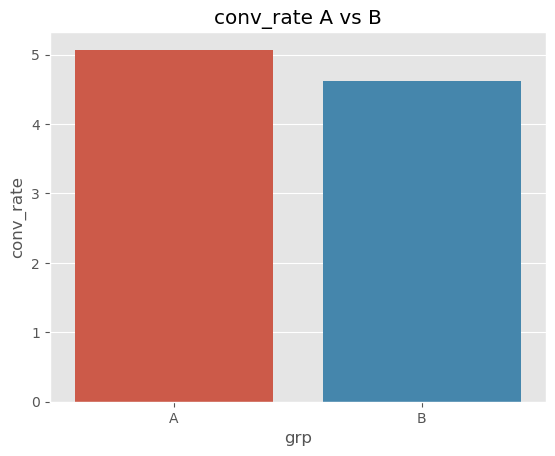

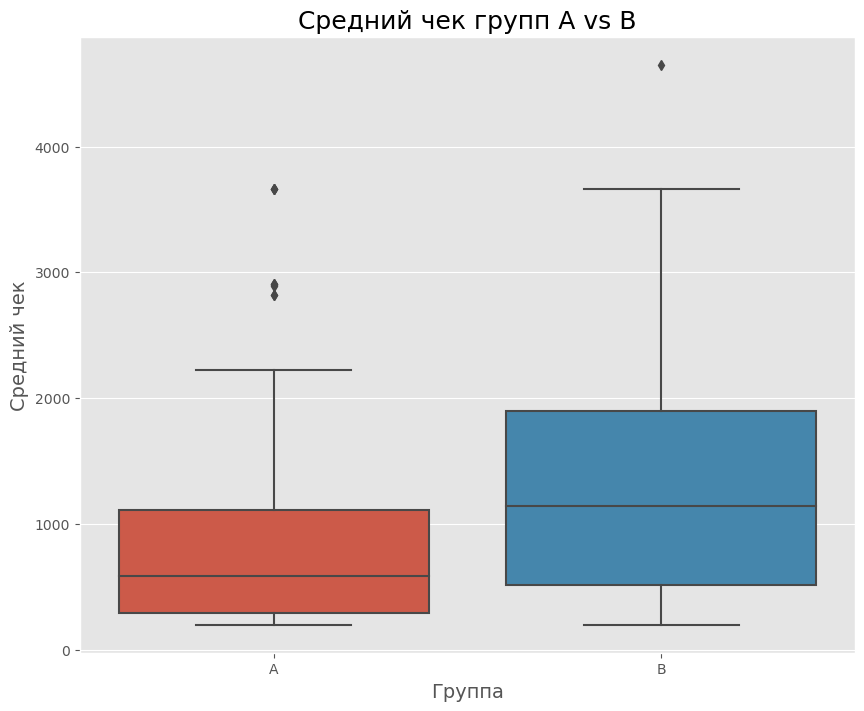

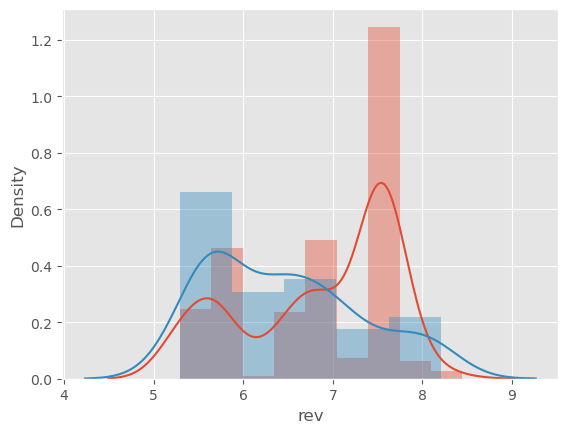

In [33]:
additional('group_add.csv', 'id', 'grp')